In [1]:
import copy
import warnings

import numpy as np
import xarray as xr

import sys, pdb, traceback

import matplotlib.pyplot as plt

import rotunno as rt
import qian_helpers
import rotunno_helpers

In [2]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport rotunno, rotunno_helpers, channel_helpers, qian_helpers

In [16]:
theta0=300
N=0.02
h=1000
delTheta=8
latitude=25
beta, Atilde, f, h = rt.calc_rotunno_parameters(N=N,theta0=theta0,delTheta=delTheta,latitude=latitude)

In [59]:
# ds_rotunno = rt.solve_rotunno_case_two(xiN=61, zetaN=31, tauN=32, kN=1000,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)
# ds_qian = rt.solve_qian(xiN=61, zetaN=31, tauN=32, sN=1000, U=0, L=0.1, alpha=3)
ds_channel = rt.solve_channel(xiN=121, zetaN=61, tauN=32, sN=1000, U=0.625, d=10, alpha=3, sigma=4, heat_island=False)


# ds_rotunno = rt.solve_rotunno_case_one(xiN=41, zetaN=21, tauN=16, xipN=200, zetapN=200,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)

Initialising
Integrating
100%|██████████| 60/60 [21:19<00:00, 21.33s/it]
Saving


In [79]:
def r1(x):
    return x+10

def r2(x):
    return x+20

1*eval('r' + str(1))(2)

12

In [4]:
ds_channel.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/first_channel.nc')

NameError: name 'ds_channel' is not defined

In [5]:
ds_channel = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/first_channel.nc')

In [60]:
omega = 2*np.pi/(24*3600)
# ds_rotunno_dim = rt.redimensionalise_rotunno(copy.deepcopy(ds_rotunno), h=h, f=f, N=N)
ds_channel_dim = rt.redimensionalise_channel(copy.deepcopy(ds_channel), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)

In [61]:
ds_channel_dim.d

1375098.7083139757

In [70]:
g=9.807
ds_channel_dim['theta_q'] = (ds_channel_dim.bq)*theta0/g
ds_channel_dim['theta_w'] = (ds_channel_dim.bw)*theta0/g
ds_channel_dim['theta_q'].attrs['units'] = 'K'
ds_channel_dim['theta_w'].attrs['units'] = 'K'

Plotting w.


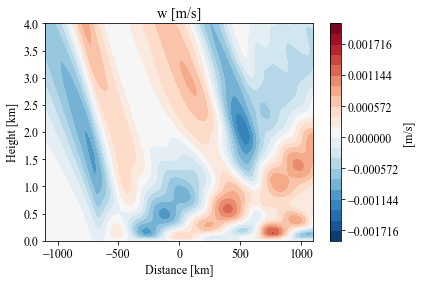

In [65]:
# rt.plotCont(ds_rotunno_dim, var='u',t=16); plt.show()
# rt.plotCont(ds_rotunno, var='u',t=8); plt.show()
# rt.plotCont(ds_test.sum(dim='mode', keep_attrs=True).squeeze(), var='u',t=0); plt.show()
rt.plotCont(ds_channel_dim.sel(mode=[1,2,3]).sum(dim='mode', keep_attrs=True).squeeze(), var='w',t=8); plt.show()
# rt.plotVelocity(ds_rotunno_dim,t=8); plt.show()

In [10]:
np.heaviside(10,0)

1.0

Plotting theta_q.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15
Timestep 16
Timestep 17
Timestep 18
Timestep 19
Timestep 20
Timestep 21
Timestep 22
Timestep 23
Timestep 24
Timestep 25
Timestep 26
Timestep 27
Timestep 28
Timestep 29
Timestep 30
Timestep 31


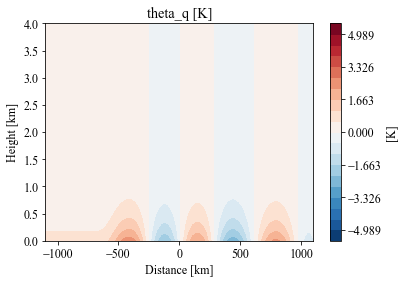

In [71]:
rt.animateCont(ds_channel_dim.sel(mode=[1,2,3]).sum(dim='mode', keep_attrs=True).squeeze(),var='theta_q')
# rt.animateCont(ds_rotunno_dim, var='theta_pert_w')

# rt.animatePsi(ds_dim.sel(mode=2).squeeze())
# rt.animateCont(ds_qian_dim.sel(mode=[1]).sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')

# rt.animateCont(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')
# rt.animateCont(ds_qian_dim.sel(mode=[2]).sum(dim='mode', keep_attrs=True).squeeze(),  var='psi')
# for i in np.arange(1,7):
#     rt.animateCont(ds_qian_dim.sel(submode=i),  var='bw')
# rt.animateCont(ds_qian_dim.sel(submode=[2,3,4,5,6]).sum(dim='submode', keep_attrs=True).squeeze(),'bw')
# rt.animateCont(ds_qian_dim.sel(mode=2).squeeze(),  var='psi')

In [147]:
ds_qian_dim['theta_pert_q'] = ds_qian_dim.bq*300/9.807
ds_qian_dim.theta_pert_q.attrs['units'] = 'K'
# ds_rotunno_dim['theta_pert_w'] = ds_rotunno_dim.bw*300/9.807
# ds_rotunno_dim.theta_pert_w.attrs['units'] = 'K'

In [67]:
# rt.animateVelocity(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze()); plt.show()
rt.animateVelocity(ds_channel_dim.sum(dim='mode', keep_attrs=True).squeeze()); 

Plotting velocity.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15
Timestep 16
Timestep 17
Timestep 18
Timestep 19
Timestep 20
Timestep 21
Timestep 22
Timestep 23
Timestep 24
Timestep 25
Timestep 26
Timestep 27
Timestep 28
Timestep 29
Timestep 30
Timestep 31


## Channel Testing

In [88]:
alpha=3
d=4
zeta=0
xi = np.linspace(-3,3,1000)
H = (1-1/(2**alpha)*(1-np.cos(2*np.pi*xi/d))**alpha)*np.heaviside(d/2-xi,0)*np.heaviside(d/2+xi,0)

dH = -np.pi*np.heaviside(d/2+xi,0)*np.sin(2*np.pi*xi/d)*np.heaviside(d/2-xi,0)/d
dH_alt = np.diff(H)/np.diff(xi)

dH2 = dH*(np.cos(2*np.pi*xi/d)-1)**2*3/4

In [160]:
def calc_psi1(xi,zeta,tau,k,U,d,sigma,r):
    m=k/(1+k*U)
    psi1 = (-4*np.pi*1j*sigma/2*np.sin(d*k/2)/(k**2+1)
            *(np.exp(1j*m*zeta)-np.exp(-zeta))
            *np.exp(1j*(k*xi+tau))*r(k,d))
    return psi1

def r3(k,d):
    r3 = (3*(d**4*k**4-40*np.pi**2*d**2*k**2+264*np.pi**4)
          /((2*np.pi-d*k)*(2*np.pi+d*k)
            *(4*np.pi-d*k)*(4*np.pi+d*k)
            *(6*np.pi-d*k)*(6*np.pi+d*k)))
    return r3

In [192]:
xi=np.linspace(-5,5,1000)
L=.01
d=4
H1 = 1/np.pi*(np.pi/2+np.arctan((xi+d/2)/L))
H2 = 1/np.pi*(np.pi/2+np.arctan((-xi+d/2)/L))
H3 = (H1+H2-1)

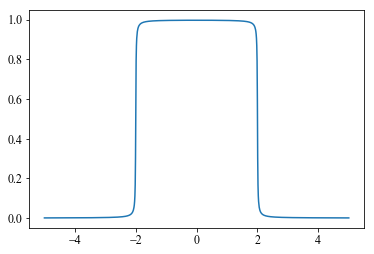

In [193]:
# plt.plot(xi,H1)
# plt.plot(xi,H2)
plt.plot(xi,H3)

In [108]:
k = np.linspace(0,5,5000)
p = calc_psi1(.1,.5,0,k,0,6,3,r3)

/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


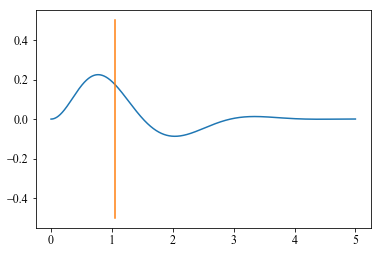

In [109]:
plt.plot(k,H)
plt.plot([2*np.pi/6,2*np.pi/6],[-.5,.5])

In [73]:
def r1(x):
    return 10
def r2(x):
    return 20

sigma=2

# Choose sigma polynomail
try:
    r = eval('r' + str(sigma))
except:
    print(('Invalid choice of sigma. \n'
           + 'sigma should be an int between 1 and 5. \n'
           + 'Defaulting to sigma = 2.'))
    sigma = 2
    r = eval('r' + str(sigma))

r(1)

Invalid choice of sigma. 
sigma should be an int between 1 and 5. 
Defaulting to sigma = 2.


20

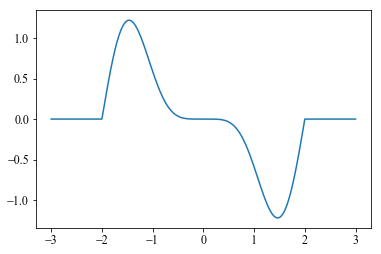

In [76]:
# plt.plot(xi,(H-1)*-1)
# plt.plot(xi,dH)
# plt.plot(xi[1:],dH_alt+1)
plt.plot(xi,dH2)

In [194]:
from sympy import *
import sympy as sp

In [195]:
x, a, k, D= symbols('x a k D')

In [196]:
init_printing()

In [6]:
sp.transforms._fourier_transform(dHsym, x, k, 1, -1, 'non-unitary',simplify=False)

IntegralTransformError: non-unitary Transform could not be computed: could not compute integral.

In [197]:
test = Heaviside(a-x)*DiracDelta(a+x)-Heaviside(a+x)*DiracDelta(a-x)
diff(test,x)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

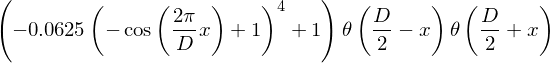

In [199]:
alpha=4
Hsym = (1-1/(2**alpha)*(1-cos(2*pi*x/D))**alpha)*Heaviside(D/2-x,0)*Heaviside(D/2+x,0)
Hsym

In [5]:
dHsym = diff(Hsym,x)
dHsym = - 1.0*pi*sin(2*pi*x/D)*Heaviside(D/2 - x, 0)*Heaviside(D/2 + x, 0)/D
dHsym

-1.0*pi*sin(2*pi*x/D)*Heaviside(D/2 - x, 0)*Heaviside(D/2 + x, 0)/D

## Rotunno Case One Dev

In [301]:
*[[1,2],[1,2]]

SyntaxError: can't use starred expression here (<ipython-input-301-1486483d8e6c>, line 1)

In [310]:
import itertools
inds = list(itertools.product(range(5),range(5)))[1:]
for [i,j] in inds:
    print(str(i)+str(j))

01
02
03
04
10
11
12
13
14
20
21
22
23
24
30
31
32
33
34
40
41
42
43
44


In [45]:
sN=1001
xi=2
s = np.arange(0,1+1/sN,1/sN)
alpha=3
theta = s**alpha*np.pi/2
xip = 2*xi-xi/(1-np.sin(theta))

/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


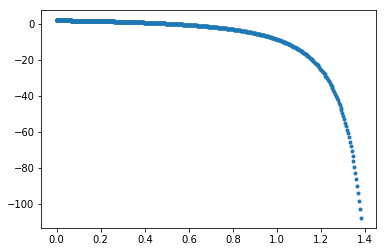

In [47]:
plt.plot(theta[:960],xip[:960],'.')

In [321]:
xip = [xip_minus, xip_plus]
xip[1].sum(axis=0)

-0.7449513398575752
-0.7450213475010908
-0.06741513647068674
-0.06748506562989355
-0.06748506562989355
-0.06748506562989355
-0.06748506562989355
-0.06748506562989355


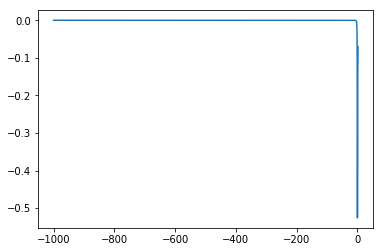

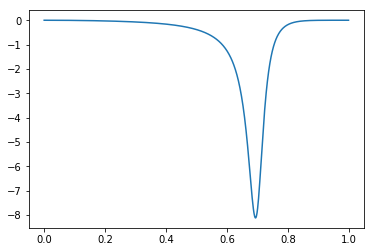

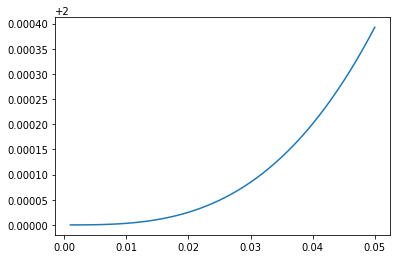

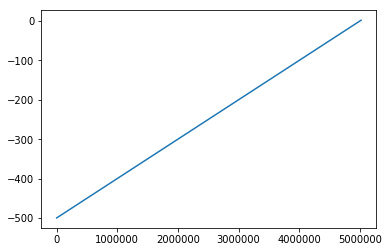

In [315]:
sN=1000
s = np.arange(1/sN,1,1/sN)
alpha=3
theta = s**alpha*np.pi/2
xip_minus = 2*xi-xi/(1-np.sin(theta))
xip_plus = xi/(1-np.sin(theta))

# zetap=np.linspace(0,10,1000)
# XIP, ZETAP = np.meshgrid(xip,zetap)
zetap=2
xi=2
zeta=1
xi0=0.5
fn1_minus = np.log(((xi-xip_minus)**2+(zeta-zetap)**2)/((xi-xip_minus)**2+(zeta+zetap)**2))*np.exp(-zetap)/(xip_minus**2+xi0**2)*xi/(1-np.sin(theta))**2*np.cos(theta)*alpha*s**(alpha-1)*np.pi/2
fn1_plus = np.log(((xi-xip_plus)**2+(zeta-zetap)**2)/((xi-xip_plus)**2+(zeta+zetap)**2))*np.exp(-zetap)/(xip_plus**2+xi0**2)*xi/(1-np.sin(theta))**2*np.cos(theta)*alpha*s**(alpha-1)*np.pi/2

w_minus = -(2*(xi-xip_minus)*(-(zeta-zetap)**2+(zeta+zetap)**2)
             /(((xi-xip_minus)**2+(zeta-zetap)**2)
               *((xi-xip_minus)**2+(zeta+zetap)**2)))
w_plus = -(2*(xi-xip_plus)*(-(zeta-zetap)**2+(zeta+zetap)**2)
             /(((xi-xip_plus)**2+(zeta-zetap)**2)
               *((xi-xip_plus)**2+(zeta+zetap)**2)))

u_minus = (2*((zeta-zetap)*((xi-xip_minus)**2
               +(zeta+zetap)**2)
               -(zeta+zetap)*((xi-xip_minus)**2
               +(zeta-zetap)**2))
            /(((xi-xip_minus)**2+(zeta-zetap)**2)
              *((xi-xip_minus)**2+(zeta+zetap)**2)))

u_plus = (2*((zeta-zetap)*((xi-xip_plus)**2
               +(zeta+zetap)**2)
               -(zeta+zetap)*((xi-xip_plus)**2
               +(zeta-zetap)**2))
            /(((xi-xip_plus)**2+(zeta-zetap)**2)
              *((xi-xip_plus)**2+(zeta+zetap)**2)))


dXip = 1/1000
xip_alt_minus = np.arange(-1000,xi,dXip)
fn1_alt_minus = np.log(((xi-xip_alt_minus)**2+(zeta-zetap)**2)/((xi-xip_alt_minus)**2+(zeta+zetap)**2))*np.exp(-zetap)/(xip_alt_minus**2+xi0**2)

xip_alt_plus = np.arange(xi+dXip,1000,dXip)
fn1_alt_plus = np.log(((xi-xip_alt_plus)**2+(zeta-zetap)**2)/((xi-xip_alt_plus)**2+(zeta+zetap)**2))*np.exp(-zetap)/(xip_alt_plus**2+xi0**2)
plt.plot(xip_alt_minus,fn1_alt_minus)
plt.figure()
plt.plot(s,fn1_minus)
plt.figure()
plt.plot(s[:50],xip_plus[:50])
plt.figure()
plt.plot(xip_alt)
print(np.trapz(fn1_alt_minus,xip_alt_minus))
print(np.trapz(fn1_minus,s))
print(np.trapz(fn1_alt_plus,xip_alt_plus))
print(np.trapz(fn1_plus,s))

print(np.trapz(fn1_plus,s))
print(np.trapz(fn1_plus,s))
print(np.trapz(fn1_plus,s))
print(np.trapz(fn1_plus,s))

In [21]:
5%2

In [148]:
np.log(((xi-xip_alt)**2+(zeta-zetap)**2)/((xi-xip_alt)**2+(zeta+zetap)**2))*np.exp(-zetap)/(xip_alt**2+xi0**2)


array([ 0.04908093,  0.04908174,  0.04908256, ..., -3.78036847,
       -3.96895674, -4.29155481])

In [141]:
fn1_alt.max()

0.0

In [9]:
from sympy import *

In [10]:
xi, xip, z, zp, xi0, epsilon_1, epsilon_2, r = symbols('xi xi_p zeta zeta_p xi0 \epsilon_1 \epsilon_2 r')

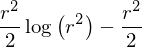

In [149]:
integrate(log(r**2)*r)

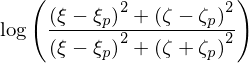

In [78]:
fn3 = log(((xi-xip)**2+(z-zp)**2)/((xi-xip)**2+(z+zp)**2))
fn3

In [16]:
init_printing()

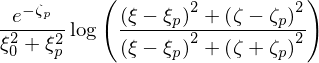

In [17]:
fn4 = (log(((xi-xip)**2+(z-zp)**2)/((xi-xip)**2+(z+zp)**2))*exp(-zp)/(xip**2+xi0**2))
# fn5 = -log((zeta-zetap)**2/(zeta+zetap)**2)*exp(-zeta)/(xi**2+xi0**2)
fn4

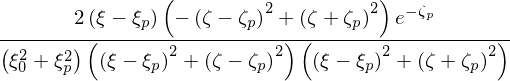

In [18]:
# limit(limit(simplify(diff(fn4, z)),zp,z),xip,xi)
# limit(limit(simplify(diff(fn4, z)),xip,xi),zp,z)
# limit(simplify(diff(fn4, z)).subs(zp,z),xip,xi)
# limit(limit(simplify(diff(fn4, xi)),zp,z),xip,xi)
simplify(diff(fn4, xi))

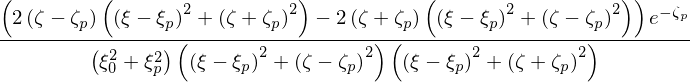

In [19]:
simplify(diff(fn4, z))

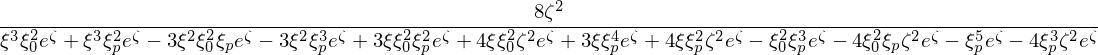

In [107]:
xip=np.linspace(-.1,.1,1000)
zetap=np.linspace(1.1,1.2,1000)

XIP, ZETAP = np.meshgrid(xip,zetap)

zeta=1.15
xi0=0.1
xi=0

y1 = np.log(((xi-XIP)**2+(zeta-ZETAP)**2)/((xi-XIP)**2+(zeta+ZETAP)**2))*np.exp(-ZETAP)/(XIP**2+xi0**2)
y2 = np.log(((xi-XIP)**2+(zeta-ZETAP)**2)/((xi-XIP)**2+(zeta+ZETAP)**2))*np.exp(-zeta)/(xi**2+xi0**2)

In [108]:
np.trapz(y1,xip,-1)

array([-36.6128718 , -36.62237273, -36.63188264, -36.64140155,
       -36.65092946, -36.66046638, -36.67001234, -36.67956734,
       -36.68913139, -36.69870451, -36.7082867 , -36.71787799,
       -36.72747838, -36.73708789, -36.74670653, -36.75633431,
       -36.76597124, -36.77561734, -36.78527262, -36.79493709,
       -36.80461077, -36.81429366, -36.82398578, -36.83368715,
       -36.84339777, -36.85311765, -36.86284682, -36.87258528,
       -36.88233305, -36.89209014, -36.90185655, -36.91163231,
       -36.92141743, -36.93121192, -36.94101579, -36.95082906,
       -36.96065174, -36.97048384, -36.98032537, -36.99017636,
       -37.0000368 , -37.00990672, -37.01978612, -37.02967502,
       -37.03957344, -37.04948139, -37.05939887, -37.0693259 ,
       -37.07926251, -37.08920869, -37.09916446, -37.10912984,
       -37.11910484, -37.12908947, -37.13908374, -37.14908767,
       -37.15910128, -37.16912457, -37.17915756, -37.18920026,
       -37.19925269, -37.20931486, -37.21938678, -37.22

In [124]:
integrate(fn4, zp)

KeyboardInterrupt: 

In [126]:
f6 = log(((xi-xip)**2+(z-zp)**2)/((xi-xip)**2+(z+zp)**2))*(xip-xi) + 2*(z-zp)*atan((z-zp)/(xi-xip))-2*(z+zp)*atan((z+zp)/(xi-xip))
integrate(f6, zp)

KeyboardInterrupt: 

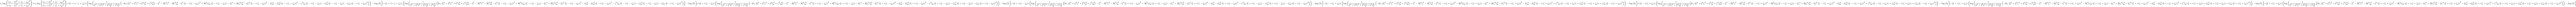

In [84]:
simplify(integrate(fn3,(xip,-epsilon_1,epsilon_1)))

In [158]:
fn = log(((xi-xip)**2+(z-zp)**2)/((xi-xip)**2+(z+zp)**2))*exp(-zp)/(xip**2+xi0**2)
fn_alt = log(((xi-xip)**2+(z-zp)**2)/((xi-xip)**2+(z+zp)**2))*exp(-z)/(xip**2+xi0**2)

integrate(fn_alt, (z, 0, oo))


KeyboardInterrupt: 

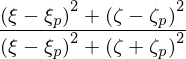

In [73]:
fn_2 = ((xi-xip)**2+(zeta-zetap)**2)/((xi-xip)**2+(zeta+zetap)**2)
fn_2
fn_2

In [4]:
init_printing()

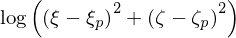

In [152]:
fn

In [17]:
simplify(integrate(integrate(fn, (xip, -oo, oo)), (zetap, 0, oo)))
# simplify(limit(integrate(fn, (xip, -epsilon_1, epsilon_1)),epsilon_1,oo))

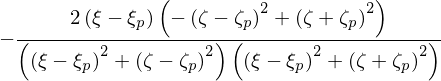

In [39]:
w=-simplify(diff(fn,xi))
w

In [103]:
limit(limit(fn,zeta,0),zetap,0)

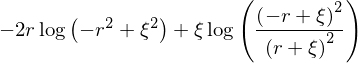

In [151]:
integrate(log((xi-r)**2/(xi+r)**2), xi)

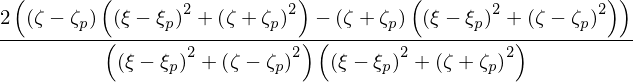

In [44]:
u=simplify(diff(fn,zeta))
u

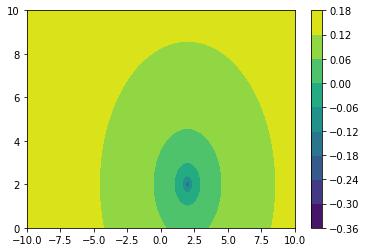

In [130]:
xip=np.linspace(-10,10,1000)
zetap=np.linspace(0,10,1000)
XIP, ZETAP = np.meshgrid(xip,zetap)
xi=2
zeta=2
xi0=0.5
fn1 = np.log(((xi-XIP)**2+(zeta-ZETAP)**2))*np.exp(-ZETAP)/(XIP**2+xi0**2)
# fn2 = np.log(((xi-XIP)**2+(zeta-ZETAP)**2)/((xi-XIP)**2+(zeta+ZETAP)**2))*np.exp(-zeta)/(xi**2+xi0**2)
fn2 = np.log(((xi-XIP)**2+(zeta-ZETAP)**2))*np.exp(-zeta)/(xi**2+xi0**2)
plt.contourf(XIP,ZETAP,fn2)
plt.colorbar()

In [119]:
print(np.trapz(np.trapz(fn1-fn2, zetap, axis=1), zetap)+np.trapz(np.trapz(fn2, zetap, axis=1), zetap))
print(np.trapz(np.trapz(fn1, zetap, axis=1), zetap))

-2.46299703057527
-2.46299703057527


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


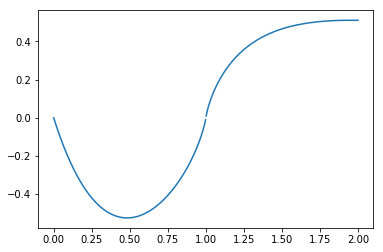

In [16]:
x=np.linspace(0,2,1001)
# y=np.log((x-1)**2/(x+1)**2)[]
y1=(np.exp(-x))*np.log((x-1)**2/(x+1)**2)
y2=(np.exp(-1))*np.log((x-1)**2/(x+1)**2)
plt.plot(x,y)

In [72]:
np.any(np.isinf(fn))

False

array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ,
       1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09])

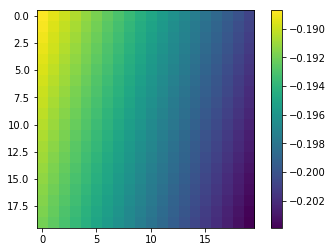

In [64]:
plt.imshow(fn[540:560,90:110])
plt.colorbar()
# xip[540:560]
zetap[90:110]

<function matplotlib.pyplot.show(*args, **kw)>

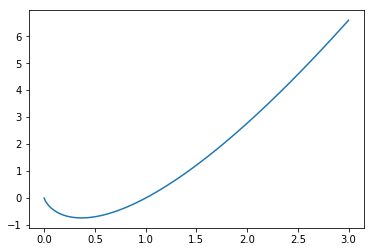

In [22]:
xx  = np.arange(1/100000,3,1/100000)
plt.plot(xx,xx*np.log(xx**2));plt.show

## Buoyancy debug

In [ ]:
from sympy import *

In [ ]:
kappa, U, x, tau, L =symbols('kappa U x tau L')
kappaU = 1/U

In [ ]:
expression = (kappa/(kappa*U-1))/(kappa**2+(U*kappa-1)**2)*exp(-kappa*L)*exp(I*(kappa*x-tau))-(2*kappaU-kappa)/(kappa*U-1)/((2*kappaU-kappa)**2+(kappa*U-1)**2)*exp(-1*(2*kappaU-kappa)*L)*exp(I*((2*kappaU-kappa)*x-tau))

In [ ]:
simplify(expression)

In [ ]:
init_printing()
expression

In [ ]:
limit(expression,kappa,kappaU)

In [ ]:
simplify(cancel(factor(cancel(expand(exp)))))

In [ ]:
theta_alt = ((1-cos(s*pi))/(2))**(alpha)*pi/2

In [ ]:
theta_alt.subs(alpha,5)

In [ ]:
diff(theta_alt.subs(alpha,2),s)

In [ ]:
init_printing()

In [ ]:
plt.close('all')
power=6
tau=np.pi/2
zeta=0.001
alpha=3
U=1.5
L=0.1
sN=1000
dS=1/sN

s=np.arange(dS,1,dS, dtype=np.float32)
xi=np.linspace(-20,20,1000, dtype=np.float32)
theta=qian_helpers.calc_theta(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)
bw23=np.zeros(xi.size)
bw23_alt=np.zeros(xi.size)
bw23a=np.zeros(xi.size)
bw23b=np.zeros(xi.size)
bw2b=np.zeros(xi.size)
bw2ba=np.zeros(xi.size)
bw2c=np.zeros(xi.size)
bw3b=np.zeros(xi.size)
bw3c=np.zeros(xi.size)

# def calc_k_2()

def calc_test(xi,zeta,tau,theta,U,L):
    test_exp = (
        U**2*(-(U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
              *np.exp((-L*(np.sin(theta) - 1)**2 + 1j*(U*tau*(-np.sin(theta) + 1) - xi))/(U*(-np.sin(theta) + 1)))
              +(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
              *np.exp((L + 1j*(np.sin(theta) - 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(np.sin(theta) - 1))))
        *np.exp(1j*(-U*tau*(-np.sin(theta) + 1) + xi - (-np.sin(theta) + 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(-np.sin(theta) + 1)))
        /((U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
          *(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
          *np.tan(theta))
    )
    return test_exp

for i in range(xi.size):
    bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23b_ig = (1/np.tan(theta)
               *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
                 +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23_ig = ((-qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2/np.tan(theta)
                +qian_helpers.calc_C3(xi[i],tau,k3,U,L)/np.tan(theta))
               *alpha*s**(alpha-1)*np.pi/2)
    
    s_app=np.concatenate(([0],s,[1]))
    bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))
    
#     bw23_ig_alt = calc_test(xi[i],zeta,tau,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
    
    bw23a[i] = np.trapz(bw23a_ig,s)*1/2*np.exp(-zeta)
    bw23b[i] = np.trapz(bw23b_ig,s)*1/2*np.exp(-zeta)
    bw23[i] = np.trapz(bw23_ig_app,s_app)*1/2*np.exp(-zeta)
#     bw23_alt[i] = np.trapz(bw23_ig_alt,s)*1/2*np.exp(-zeta)
    bw2c[i] = (1/(2*U**2)*np.exp(1j*zeta/U)
               *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
               *qian_helpers.calc_exp1(1j*zeta/U))
    bw2b[i] = np.trapz(qian_helpers.calc_bw2b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3b[i] = np.trapz(qian_helpers.calc_bw3b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3c[i] = (-1/2*qian_helpers.calc_C3(xi[i],tau,k0_3,U,L)
                        *qian_helpers.calc_exp1(-1j*zeta/U))
    
    # Calc psi2
    psi2a_ig = qian_helpers.calc_psi2a(xi[i],zeta,tau,s,alpha,U,L)
    psi2b_ig = qian_helpers.calc_psi2b(xi[i],zeta,tau,s,alpha,U,L)
    
    psi2c = (-1/(2*U)*np.exp(1j*zeta/U)
             *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
             *qian_helpers.calc_ep0(-1j*zeta/U))

    psi2ab = np.trapz(psi2a_ig+psi2b_ig, s)
    bw2ba[i] = (psi2ab+psi2c)/U
        
# plt.figure(figsize=(12,8))
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23_alt,label='bw23')
# plt.plot(xi,np.zeros(xi.size),'--k')
# plt.plot(xi,bw2b,label='bw2b')
# plt.plot(xi,bw2c,label='bw2c')
# plt.plot(xi,bw3b,label='bw3b')
# plt.plot(xi,bw3c,label='bw3c')
# plt.plot(s,k2,'.')
# plt.plot(s[0:4000],k3[0:4000]-1.25,'.')

# plt.figure(figsize=(12,8))
# plt.plot(s[0:800],k3[0:800],'.')

# plt.legend()
# plt.show()
plt.figure(figsize=(12,8))

# plt.plot(xi,bw2ba,label='bw2ba')
# plt.plot(xi,bw3b+bw3c+bw2b,label='bw3b+bw3c')
plt.plot(xi,bw2b+bw2c+bw3b+bw3c,label='all')
# plt.plot(xi,bw2c,label='bw2b+bw2c')
# plt.plot(xi,bw23_alt,label='bw23_alt')
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23,label='bw23')
# plt.plot(xi,bw23+bw2ba,label='bw23')
# plt.plot(xi,bw3b+bw3c+bw23+bw23+bw2c,label='all')
# plt.plot(xi,bw23a+bw23b,label='bw23a+bw23b')
# plt.plot(xi,bw23,label='bw23')
plt.plot(xi,np.zeros(xi.size),'--k')
plt.legend()
plt.show()

In [ ]:
plt.plot(k3_alt[0:4000])

In [ ]:
bw23_ig_app[np.isnan(bw23_ig_app)]=0

In [ ]:
bw23_ig_app

In [ ]:
print(bw23b_ig[-1])
print(bw23a_ig[-1])
print(bw23_ig[-1])

print(bw23b_ig[0])
print(bw23a_ig[0])
print(bw23_ig[0])

In [ ]:
s_app=np.concatenate(([0],s,[1]))
bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))

plt.plot(s_app,bw23_ig_app)
plt.plot(s_app,np.zeros(s_app.size),'--k');
plt.show()

# plt.plot(s[200:],bw23a_ig[200:])
# plt.plot(s[200:],bw23b_ig[200:])

In [ ]:

k2_app = np.concatenate((k2,[0]))
plt.plot(k2_app[-10:],'.'); plt.show()

In [ ]:
plt.plot(bw23a_ig); plt.show()

In [ ]:
plt.plot(s[0:30000],k3[0:30000],'.')
plt.plot(s,k2,'.')

In [ ]:
def calc_theta_alt(s,alpha=1):
    theta_alt = ((1-np.cos(s*np.pi))/(2))**(alpha)*np.pi/2
    return theta_alt

def calc_dtheta_alt(s,alpha=1):
    dtheta_alt = (np.pi/2*alpha*((1-np.cos(s*np.pi))/2)**(alpha-1)
                  *np.sin(s*np.pi)*np.pi/2)
    return dtheta_alt

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(s[200:2500],k3[200:2500],'.',size=0.1)

In [ ]:
plt.plot(s,k2,'.')

In [ ]:
# plt.plot(s,theta_alt)
alpha=0.75
theta_alt=calc_theta_alt(s,alpha)
k2 = qian_helpers.calc_k_2(theta_alt,U)
k3 = qian_helpers.calc_k_3(theta_alt,U)

plt.plot(s,calc_theta_alt(s, alpha))
# plt.plot(s,calc_theta_alt(s))
# k2_alt = qian_helpers.calc_k_2(calc_theta_alt(s),U)
# k3_alt = qian_helpers.calc_k_3(calc_theta_alt(s),U)
# plt.plot(s[0:100],k3_alt[0:100],'.')
plt.plot(s,calc_dtheta_alt(s,alpha=alpha))
plt.plot(s,k2)
plt.plot(s[:-3000],k3[:-3000])

In [ ]:
x=-20.10
alpha=3
U=0.6
tau=3
L=0.1
sN=5000
dS=1/sN

s=np.arange(dS,1,dS,dtype=np.float128)
theta=calc_theta_alt(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)

# bw23a_ig = (1/np.tan(theta)
#                *(
#                  -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
# #                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
#                 )
#                *alpha*s**(alpha-1)*np.pi/2)
# bw23b_ig = (1/np.tan(theta)
#            *(
# #                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#              +qian_helpers.calc_C3(x,tau,k3,U,L)
#             )
#            *alpha*s**(alpha-1)*np.pi/2)

bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
#                *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
                *calc_dtheta_alt(s,alpha))
bw23b_ig = (1/np.tan(theta)
           *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
             +qian_helpers.calc_C3(x,tau,k3,U,L)
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))
bw23_ig = (1/np.tan(theta)
           *(
             -qian_helpers.calc_C2(x,tau,k2,U,L)
             +qian_helpers.calc_C3(x,tau,k3,U,L)*U**2
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))

where_nan = np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))
bw23a_ig[where_nan]=0
bw23b_ig[where_nan]=0
bw23_ig[np.isnan(bw23_ig)]=0

# plt.plot(theta[3:10],bw23a_ig[3:10],label='a')
# plt.plot(theta[3:10],bw23b_ig[3:10],label='b')
# plt.plot(theta,(bw23b_ig+bw23a_ig),label='a+b')
plt.plot(theta,bw23_ig/U**2, label='a+b')
plt.plot(theta, np.zeros(theta.size),'--k')
plt.legend()

# s_app = np.concatenate(([0],s,[1]))
# bw

print(np.trapz(bw23a_ig,s))
print(np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig,s)+np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig+bw23b_ig,s))
print(np.trapz(bw23_ig/U**2,s))


In [ ]:
plt.plot(np.tan(np.arange(0,np.pi/8,np.pi/(2*5000)))+1/U,'.')

In [ ]:
# Alternative approach
sN=2000
dk = (1/U)/sN
s=np.arange(1/sN,1,1/sN)
U=0.5
L=0.5
alpha=1

k2 = (1-s**alpha)/U

k3 = np.tan((np.arange(0,1+1/sN,1/sN))*np.pi/2)+2/U
x=10
tau=0
zeta=0.00001

def calc_exp_terms(xi,tau,k,L):
    return np.exp(-k*L)*np.exp(1j*(k*xi-tau)) 

# bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2/(U*k2-1)*alpha*s**(alpha-1)
bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2*alpha*s**(alpha-1)
# bw2a_ig_alt = qian_helpers.calc_C2(x,tau,k2,U,L)*alpha*s**(alpha-1)
bw2a_ig[np.isinf(bw2a_ig)]=0

k2P = -k2+2/U

# bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P/(1-U*k2)*alpha*s**(alpha-1)
bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P*alpha*s**(alpha-1)
# bw3a1_ig_alt = qian_helpers.calc_C2(x,tau,k2P,U,L)*alpha*s**(alpha-1)
bw3a1_ig[np.isinf(bw3a1_ig)]=0

bw3a2_ig = qian_helpers.calc_C2(x,tau,k3,U,L)*k3/(U*k3-1)

# plt.plot(k2[-10:],'o')
# plt.plot(k3[:10],'o')
# plt.plot(k3[:10]*0+2,'--')

# *np.exp(-zeta)

lb=0
ub=100

# plt.plot(s,bw2a_ig+bw3a1_ig)
plt.plot(s,bw2a_ig,label='bw2a')
plt.plot(s,bw3a1_ig, label='bw3a1')
plt.plot(s,(-bw3a1_ig+bw2a_ig)/(k2*U-1), label='sum')
plt.legend()
print(np.trapz((-bw3a1_ig+bw2a_ig)/(k2*U-1),s))
plt.plot()
# plt.plot(k2,bw2a_ig)
plt.figure()
plt.plot(np.arange(0,1+1/sN,1/sN),bw3a2_ig)
print(np.trapz(bw3a2_ig,k3))

# plt.plot(np.concatenate((bw2a_ig,bw3a_ig)))
# print(np.trapz(bw2a_ig[:100],k2[:100]))
# print(np.trapz(bw3a_ig[100:],k3[100:]))
# print(np.trapz(bw2a_ig[-100:],k2[-100:]))
# print(np.trapz(bw3a_ig[0:100],k3[0:100]))

In [ ]:
-2*0.5*np.exp(-1)-2*0.5*np.exp(-1)

In [ ]:
((-bw3a1_ig+bw2a_ig)/(k2*U-1))[0]

In [ ]:
(-bw3a1_ig+bw2a_ig)

In [ ]:
print(bw2a_ig[0:5])
print(bw3a1_ig[0:5])

In [ ]:
plt.plot(s,k2)

In [ ]:
(bw2a_ig)[:10]
(bw3a1_ig)[:10]

In [ ]:
print(bw3a1_ig[[0,-1]])
print(bw2a_ig[[0,-1]])

In [ ]:
(bw2a_ig+bw3a1_ig)[-1]

In [ ]:
(bw2a_ig+bw3a1_ig)[-10:]

In [ ]:
plt.plot(k2P)

In [ ]:
np.trapz(bw3a2_ig,s)

In [ ]:
lb=0
ub=None
print(np.trapz(bw23_ig[lb:ub],s[lb:ub]))
print(theta[lb])
print(theta[ub])
print('k2 bounds')
print(k2[lb])
print(k2[ub])
print('k3 bounds')
print(k3[lb])
print(k3[ub])

In [ ]:
bw23_ig.max()

In [ ]:
plt.plot(k3[0:800],'.')

In [ ]:
np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))

# bw23b_ig[-10:]

In [ ]:
plt.plot(theta)

In [ ]:
ig=(bw23b_ig+bw23a_ig)
ig[np.isnan(bw23b_ig+bw23a_ig)]=0
np.trapz(ig,s)

In [ ]:
bw23_ig_alt_1 = calc_test(-10.00,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_2 = calc_test(-10.20,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_3 = calc_test(-10.40,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_4 = calc_test(-10.60,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2

plt.plot(bw23_ig_alt_1)
print(np.trapz(bw23_ig_alt_1,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_2)
print(np.trapz(bw23_ig_alt_2,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_3)
print(np.trapz(bw23_ig_alt_3,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_4)
print(np.trapz(bw23_ig_alt_4,s)*1/2*np.exp(-zeta))

In [ ]:
k3[8000]

In [ ]:
len(k2)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(s[0:500],k3[0:500],'.')